# Support Vector Machines (SVM)

In [1]:
%matplotlib inline

from itertools import combinations

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

## Load Data

In [3]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0CSPPHXXV,Apple Watch Ultra 2 (GPS + Cellular 49mm) Rugg...,https://m.media-amazon.com/images/I/814xH1gpid...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Rugged-T...,699.97,2024-02-01,779.99,NaN,NaN
1,B0BDJ4MGFQ,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91WpS8h5Jv...,False,4.7,4100.0,https://www.amazon.com/Apple-Cellular-Starligh...,689.00,2024-02-01,799.00,NaN,NaN
2,B0CSV7LK7D,AppleWatch Series 9 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61DZ+Vezk0...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,679.00,2024-02-01,679.00,NaN,NaN
3,B0B8GHHD2F,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/51aQmgx9Ql...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
4,B0B8GDV9GN,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61O671oWHg...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1389694,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1389695,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1389696,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1389697,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


## Data 

In [4]:
# Make DF of products that have a calculable price difference over time
df_same = df_az[df_az["Asin"].duplicated(keep=False)].sort_values(["Asin", "Date Scraped"]).reset_index()
diffs = df_same[["Asin", "Date Scraped", "Price", "List Price"]].set_index("Asin").groupby(level=0).diff().reset_index()
df_same["Price Diff"] = diffs["Price"]
df_same["List Price Diff"] = diffs["List Price"]
df_same["Price Diff"] = df_same["Price Diff"].bfill(limit=1)
df_same["Increased"] = df_same["Price Diff"] > 0
df_same["Category"] = df_same["Category"].ffill().cat.remove_unused_categories()

# Use initial price and data, in order to predict later price change
df_diff = df_same[df_same["Date Scraped"] > pd.Timestamp("2023-11-01")]

# Only use data with `Category` categories that have more than 5 products occuring
df_diff = df_diff[df_diff.groupby("Category")["Category"].transform('count').ge(5)]
df_diff["Category"] = df_diff["Category"].cat.remove_unused_categories()

# Scale numerical data to [0, 1], make bool `Is Best Seller` an int
df_svm = df_diff[["Is Best Seller", "Stars", "Reviews", "Price", "List Price", "Bought In Month"]]
df_svm["Is Best Seller"] = df_svm["Is Best Seller"].astype(int)
df_svm = (df_svm-df_svm.min())/(df_svm.max()-df_svm.min())

df_svm["Price Increased"] = df_diff["Increased"]

# One-hot encode categorical var `Category`
df_svm = pd.concat([df_svm, pd.get_dummies(df_diff["Category"], dtype=int)], axis="columns").fillna(0)

# Split into train/test, stratifying on the prediction label
X_train, X_test, y_train, y_test = train_test_split(df_svm.drop(columns="Price Increased"), df_svm["Price Increased"], random_state=42, stratify=df_svm["Price Increased"])

df_svm

/var/folders/zp/mp995dgx1cd34p1jkbfl8g600000gq/T/ipykernel_65070/1594760188.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Is Best Seller,Stars,Reviews,Price,List Price,Bought In Month,Price Increased,Men's Clothing,Men's Shoes,Televisions & Video Products,...,Cell Phones & Accessories,Cat Supplies,Home Lighting & Ceiling Fans,Women's Shoes,Legacy Systems,Backpacks,Laptop Bags,Automotive Interior Accessories,Food Service Equipment & Supplies,Travel Accessories
1,0.0,0.869565,0.100297,0.002021,0.001882,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.869565,0.007596,0.058193,0.054194,0.0,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0.826087,0.133650,0.145819,0.185980,0.0,False,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0.0,0.869565,0.345875,0.103467,0.096358,0.0,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.0,0.478261,0.306469,0.043779,0.089371,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,0.0,0.869565,0.010801,0.029959,0.027900,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3325,0.0,0.260870,0.000950,0.003017,0.004065,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3327,0.0,0.521739,0.031691,0.548588,0.562317,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3329,0.0,0.913043,0.311454,0.027264,0.098152,0.0,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pd.concat([df_svm.iloc[:,:6], df_diff["Category"]], axis="columns")
print(pd.concat([df_svm.iloc[:,:6], df_diff["Category"]], axis="columns").sample(6).to_markdown(index=False))

|   Is Best Seller |    Stars |   Reviews |      Price |   List Price |   Bought In Month | Category                                    |
|-----------------:|---------:|----------:|-----------:|-------------:|------------------:|:--------------------------------------------|
|                0 | 0.869565 | 0.0104451 | 0.0784525  |   0.0805891  |                 0 | PlayStation 5 Consoles, Games & Accessories |
|                0 | 0.913043 | 0.0129377 | 0.0649819  |   0.0605171  |                 0 | Heating, Cooling & Air Quality              |
|                0 | 0.695652 | 0.0020178 | 0.00691039 |   0.00643559 |                 0 | Heating, Cooling & Air Quality              |
|                0 | 0.913043 | 0.131039  | 0.0333396  |   0.0310489  |                 0 | Outdoor Recreation                          |
|                0 | 0.782609 | 0.486884  | 0.040708   |   0.0605171  |                 0 | Heating, Cooling & Air Quality              |
|                1 | 0.73913  | 0.

In [6]:
# print(X_test["Category"].unique(), X_train["Category"].unique())
print(y_test.sum(), len(y_test),  y_train.sum(), len(y_train), len(X_train.columns), len(X_test.columns))

100 394 299 1180 68 68


## Run SVM

In [7]:
rbf_params = {"kernel": ["rbf"], "C": [0.5, 1, 10, 100], "gamma": ["auto", "scale", 0.01, 0.001, 0.0001]}
poly_params = {"kernel": ["poly"], "C": [0.5, 1, 10, 100], "degree": [2, 3, 4], "coef0": [0.5, 1, 5]}
lin_params = {"kernel": ["linear"], "C": [0.5, 1, 10, 100]}

gs_rbf = GridSearchCV(estimator=SVC(random_state=42), param_grid=rbf_params, n_jobs=-1, scoring="balanced_accuracy")
gs_poly = GridSearchCV(estimator=SVC(random_state=42), param_grid=poly_params, n_jobs=-1, scoring="balanced_accuracy")
gs_lin = GridSearchCV(estimator=SVC(random_state=42), param_grid=lin_params, n_jobs=-1, scoring="balanced_accuracy")

all_gs = [gs_rbf, gs_lin, gs_poly]
results = pd.DataFrame()

for gs in all_gs:
    print(f"fitting {gs}")
    gs.fit(X_train, y_train)
    results = pd.concat([results, pd.DataFrame(gs.cv_results_)], ignore_index=True)

results

fitting GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100],
                         'gamma': ['auto', 'scale', 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='balanced_accuracy')
fitting GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100], 'kernel': ['linear']},
             scoring='balanced_accuracy')
fitting GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100], 'coef0': [0.5, 1, 5],
                         'degree': [2, 3, 4], 'kernel': ['poly']},
             scoring='balanced_accuracy')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_coef0,param_degree
0,0.149385,0.017917,0.114074,0.014798,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
1,0.146281,0.014873,0.092659,0.010168,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
2,0.090047,0.010131,0.093123,0.004821,0.5,0.01,rbf,"{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
3,0.088208,0.008466,0.080050,0.005552,0.5,0.001,rbf,"{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
4,0.079076,0.006827,0.080452,0.003627,0.5,0.0001,rbf,"{'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
5,0.105468,0.003940,0.092402,0.004420,1,auto,rbf,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
6,0.125181,0.006894,0.096022,0.008877,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.500000,0.497159,0.500000,0.497159,0.494350,0.497734,0.002116,18,NaN,NaN
7,0.096763,0.005311,0.086377,0.007161,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
8,0.078800,0.006093,0.080873,0.008452,1,0.001,rbf,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN
9,0.077611,0.006061,0.083698,0.004297,1,0.0001,rbf,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,NaN,NaN


## Results

In [8]:
results_pr = results[["param_kernel", "param_C", "param_gamma", "param_degree", "param_coef0", "mean_test_score"]]
results_pr.columns = ["Kernel", "C", "Gamma", "Degree", "R", "Accuracy Score"]
print(results_pr.sort_values(["Kernel", "C", "Accuracy Score"], ascending=False).groupby(["Kernel", "C"]).head(1).fillna("").to_markdown(index=False))

| Kernel   |     C | Gamma   | Degree   | R   |   Accuracy Score |
|:---------|------:|:--------|:---------|:----|-----------------:|
| rbf      | 100   | scale   |          |     |         0.504703 |
| rbf      |  10   | scale   |          |     |         0.50571  |
| rbf      |   1   | auto    |          |     |         0.5      |
| rbf      |   0.5 | auto    |          |     |         0.5      |
| poly     | 100   |         | 4        | 5   |         0.533724 |
| poly     |  10   |         | 4        | 5   |         0.527729 |
| poly     |   1   |         | 4        | 5   |         0.515871 |
| poly     |   0.5 |         | 4        | 5   |         0.512152 |
| linear   | 100   |         |          |     |         0.493075 |
| linear   |  10   |         |          |     |         0.493075 |
| linear   |   1   |         |          |     |         0.493075 |
| linear   |   0.5 |         |          |     |         0.498302 |


In [129]:
[gs.best_estimator_.class_weight_ for gs in all_gs]

[array([1., 1.]), array([1., 1.]), array([1., 1.])]

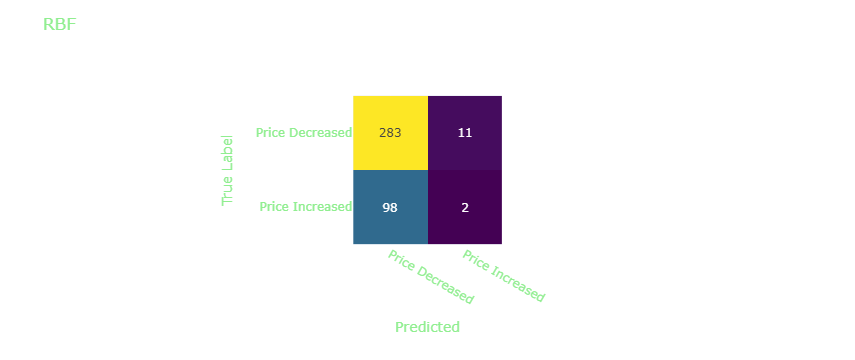

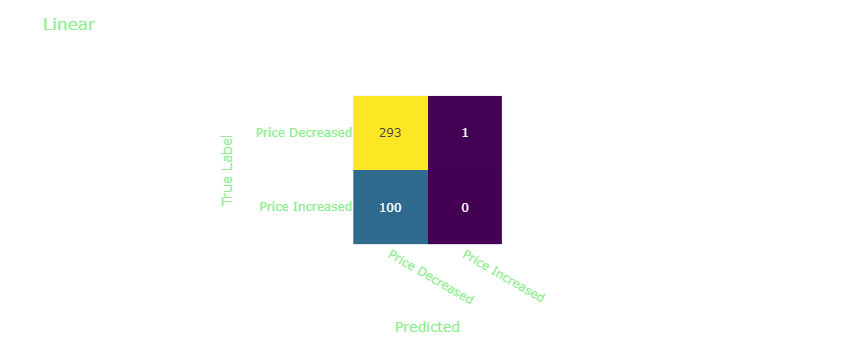

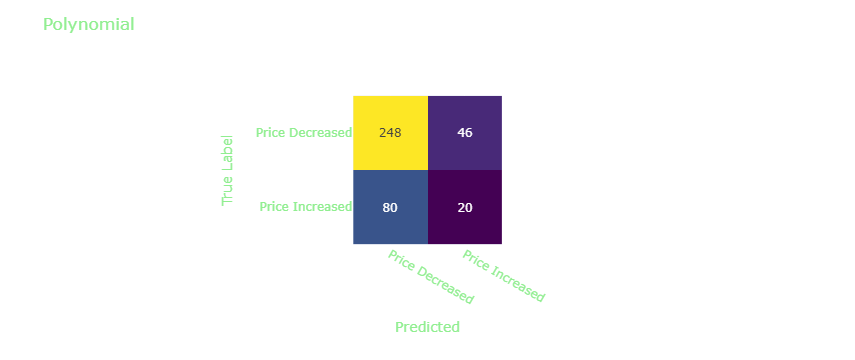

In [9]:
accuracy_score(y_test, gs_rbf.best_estimator_.predict(X_test))

labs = ["Price Decreased", "Price Increased"]

for t, gs in zip(["RBF", "Linear", "Polynomial"], all_gs):
    fig = px.imshow(confusion_matrix(y_test, gs.best_estimator_.predict(X_test)), x=labs, y=labs, text_auto=True)
    fig.update_layout(
        xaxis_title="Predicted",
        yaxis_title="True Label",
        title=t,
        coloraxis_showscale=False)
    fig.show()

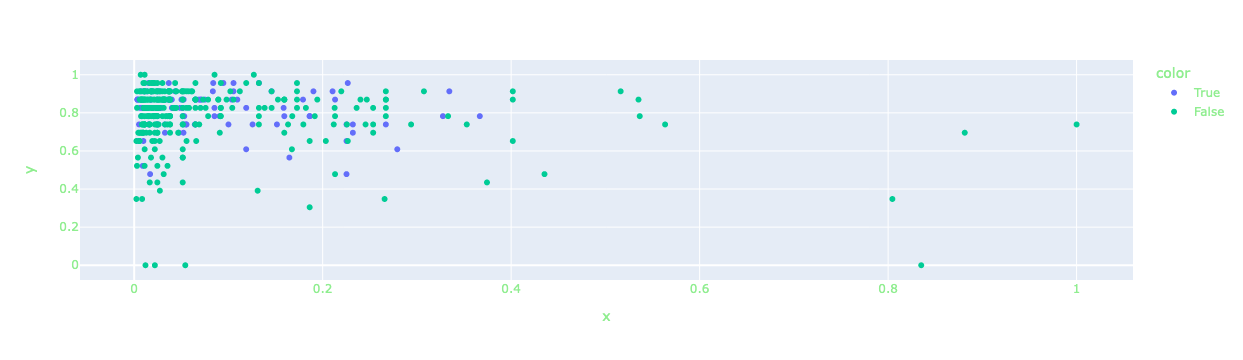

In [130]:
px.scatter(x=X_test["Price"], y=X_test["Stars"], color=y_test)

### Decision Boundaries

(202, 365, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



(365, 18, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



(202, 229, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



(202, 18, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



(229, 365, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



(229, 18, 68)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.



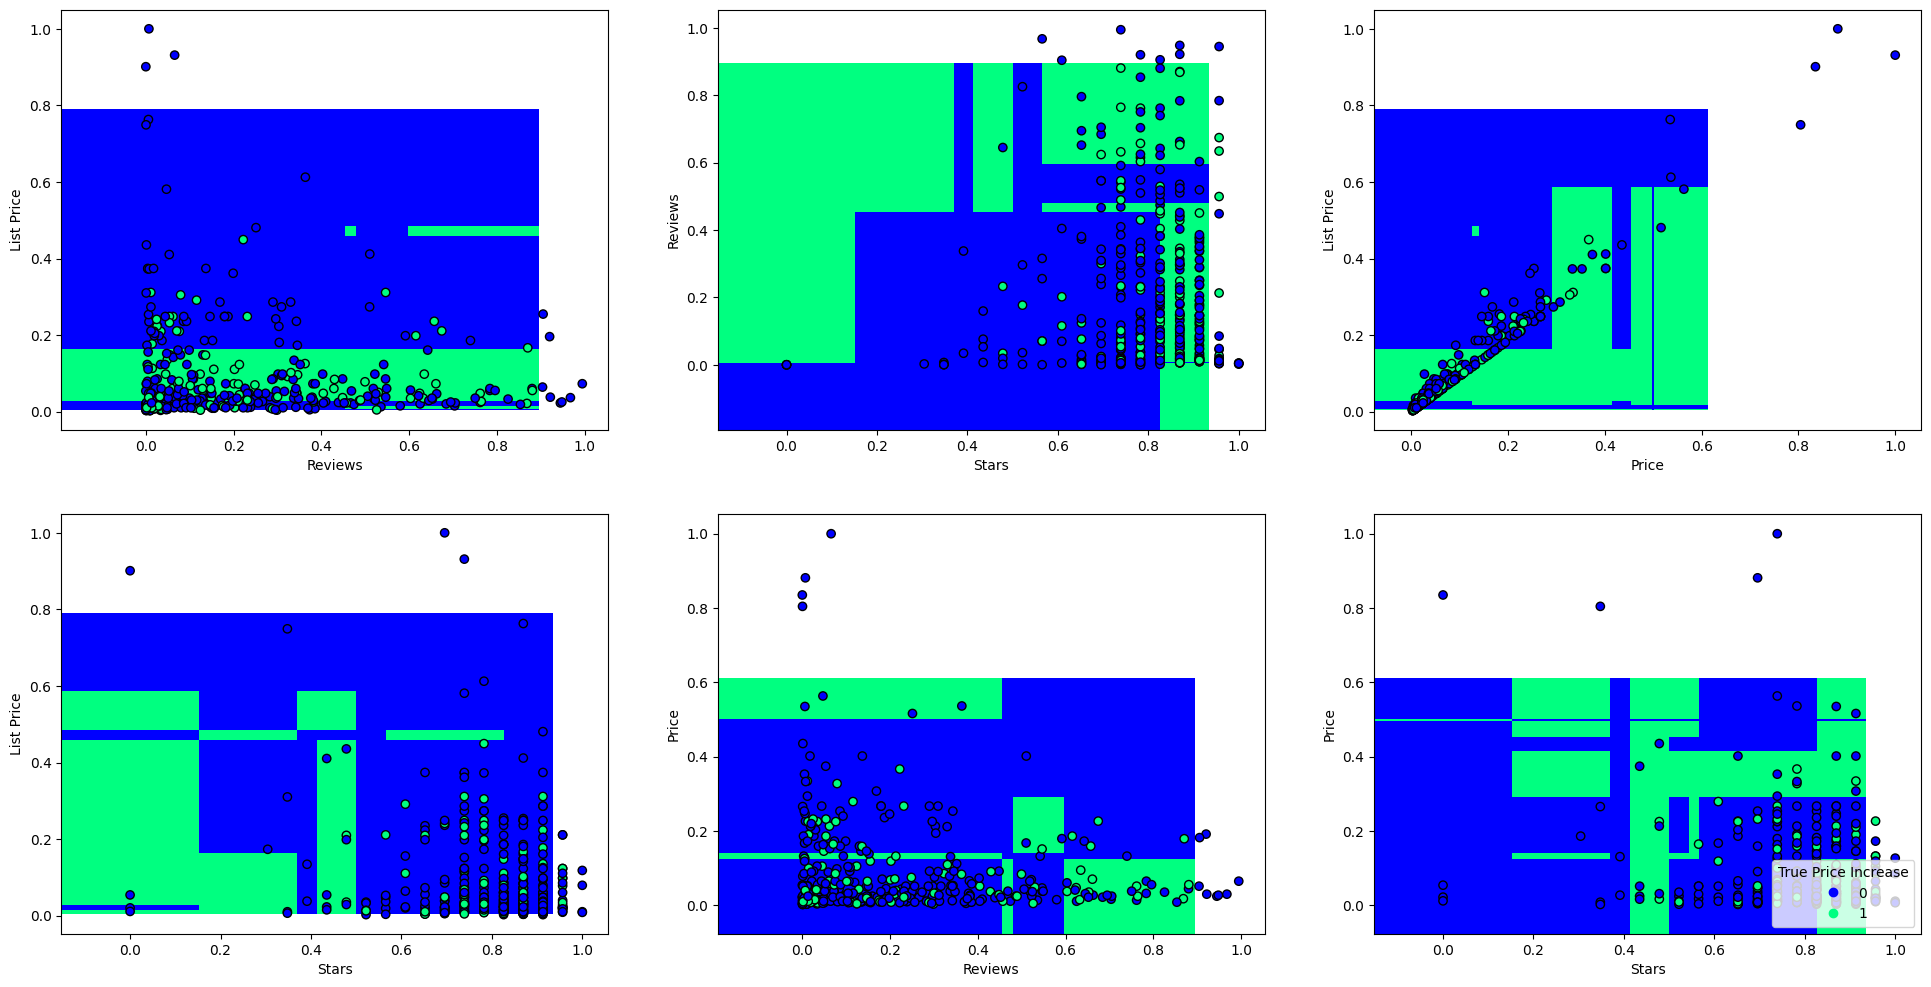

In [13]:
col_combs = list(set(combinations(np.arange(1, 5), 2)))

mainfig = plt.figure(figsize=(24, 12))

# cols = col_combs[-2]
for i, cols in enumerate(col_combs):

    xname = X_test.columns[cols[0]]
    yname = X_test.columns[cols[1]]
    
    xs = list(set(sorted(X_test[xname])))
    ys = list(set(sorted(X_test[yname])))
    gr_x, gr_y = np.meshgrid(xs, ys)
    
    x_fixed = len(xs) < len(ys)

    ## Create grid of input values based on fixing one value and picking most similar
    ## values from non-fixed axis
    if x_fixed:
        vals = np.empty((len(ys), 0, len(X_test.columns)))
        
        for x in xs:
            sub = X_test[X_test[xname] == x]
            vals = np.append(vals, sub.loc[list(map(lambda i: (sub[yname]- i).abs().idxmin(), ys)), :].to_numpy()[:, np.newaxis, :], axis=1)
        # replace with original values
        vals[:, :, cols[1]] = gr_y
    else:
        vals = np.empty((0, len(xs), len(X_test.columns)))
        
        for y in ys:
            sub = X_test[X_test[yname] == y]
            vals = np.append(vals, sub.loc[list(map(lambda i: (sub[xname]- i).abs().idxmin(), xs)), :].to_numpy()[np.newaxis, ...], axis=0)
        # replace with original values
        vals[:, :, cols[0]] = gr_x
            
    
    print(vals.shape)
    
    
    
    # grid = np.vstack([feat_price.ravel(), feat_stars.ravel()]).T
    X_test_grid = np.vstack([vals[:, :, i].ravel() for i in range(len(X_test.columns))]).T
    
    y_pred_grid = np.reshape(gs_poly.best_estimator_.predict(X_test_grid), gr_x.shape)

    ## plotting
    
    # Defining a grid of 5 columns and 3 rows 
    ax = plt.subplot(2, 3, i + 1)
    
    display = DecisionBoundaryDisplay(
     xx0=gr_x, xx1=gr_y, response=y_pred_grid, xlabel=xname, ylabel=yname
    )
    display.plot(ax=ax, cmap=plt.cm.winter, plot_method="pcolormesh")
    # display.plot(ax=ax, cmap=plt.cm.winter)
    
    fig = display.ax_.scatter(
     X_test[xname], X_test[yname], c=y_test, edgecolor="black", cmap=plt.cm.winter
    )

# plt.title("Decision boundaries made by best RBF SVM") 
plt.legend(*fig.legend_elements(), loc="lower right", title="True Price Increase")
plt.show()



In [234]:
vals[:, :, 1] = gr_x
vals[:, :, 1]

array([[0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029],
       [0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029],
       [0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029],
       ...,
       [0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029],
       [0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029],
       [0.01378038, 0.05148445, 0.00299046, ..., 0.05420551, 0.22662859,
        0.02457029]])

In [198]:
(f[xname]- tstx[0]).abs().argsort().index[0]
(f[xname]- tstx[0]).abs().idxmin()

3075

In [197]:
f.iloc[(f[xname]- tstx[0]).abs().argsort()][:1]

,Is Best Seller,Stars,Reviews,Price,List Price,Bought In Month,Men's Clothing,Men's Shoes,Televisions & Video Products,Vacuum Cleaners & Floor Care,...,Cell Phones & Accessories,Cat Supplies,Home Lighting & Ceiling Fans,Women's Shoes,Legacy Systems,Backpacks,Laptop Bags,Automotive Interior Accessories,Food Service Equipment & Supplies,Travel Accessories
3075,0.0,0.0,0.000237,0.012002,0.011178,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
np.append(, f.loc[list(map(lambda i: (f[xname]- i).abs().idxmin(), tstx)), :].to_numpy()[np.newaxis, ...], axis=0).shape

(1, 229, 68)